# PINN for Uniform Rectilinear Motion

## Importing Necessary Packages

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
import numpy as np
from matplotlib import pyplot as plt


## Determining Equation of Motion

Below a Python function is developed to facilitate the development of our mathematical function, which afterwards will be used to define the network's loss function.   

Given we are dealing with a Uniform Rectilinear Motion (URM), the differential equation is given by

\begin{equation}
    \dfrac{dx}{dt} - v = 0,
\end{equation}

with boundary condition given by

\begin{equation*}
    x(t=0) = 10
\end{equation*}

where $x$ refers to a temporal function of position, $t$ to time and $v$ to a constant velocity. Basically, this equation describes the movement of a body with constant velocity.

For the purpose of this study, the domains considered will be

\begin{equation*}
    t \in \left[ 0,1 \right]
\end{equation*}

and

\begin{equation*}
    v = 2.
\end{equation*}

## Network's Architecture

In the following cell, we define the archictecture's hyperparameters, note that the activation function applied here is a hyperbolic tangent (Tanh) for it being non-linear and ranging from -1 to 1. It is also interesting to pay attention to the fact that we are building the linear neural network from scratch due the lack of a PyTorch module specific for it, i.e., we are building a custom module.

In [22]:
class LinearNN(nn.Module):
    def __init__(
            self,
            num_inputs: int=1,
            num_layers: int=5,
            num_neurons: int=11,
            act: nn.Module = nn.Tanh()
    ) -> None:
        super().__init__()
        self.num_inputs = num_inputs
        self.num_neurons = num_neurons
        self.num_layers = num_layers

        layers = []

        # Input layer
        layers.append(nn.Linear(self.num_inputs, num_neurons))

        # Hidden layers
        for _ in range(num_layers):
            layers.extend([nn.Linear(num_neurons, num_neurons), act])

        # Output layers
        layers.append(nn.Linear(num_neurons, 1))

        # Building the network as sequential
        self.network = nn.Sequential(*layers)

    # Setting up the output
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return self.network(x.reshape(-1,1)).squeeze()

## Loss Function

Here the loss function for our network will be defined, we begin by defining the initial conditions $x0 = x(t=0) = 10$ and $v=2$, afterwards a tensor of 100 elements is defined to receive the possible temporal coordinates that the model may assume. Considering the initial conditions established and the temporal tensor,  it is now possible to define a function that returns the position $x$ at a given time.

In [23]:
# Random list of 100 temporal cordinates in 1D
t = torch.rand(100, 1)

# Position coordinate of a border
x0 = 10
# Velocity
v = 2

def x_analytical(t):
   return x0 + v*t

Finally, the model and training data are created, hence providing enough resources to define the loss function itself, which is defined by applying the model to the temporal training data (generating thereafter the $x_pred$ variable), the loss will also consider the temporal derivative of the position predicted thus it is also computed.

In conclusion, the loss function will return the mean squared error between the predicted and actual values through two different methods. The first method considers equation (1) whilst substituing the first term by the one predicted by the model. As for the second method, it considers de position provided by the model against the analytical result.

In [24]:
# Running the structure created
model = LinearNN()

# Parameters for training
t_train = torch.rand(100,1, requires_grad =True)

x_analytic = x_analytical(t_train)

# Loss function
def loss_fn(model, t_train):

    x_pred = model(t_train)
    xt_train_dot = grad(x_pred, t_train, grad_outputs=torch.ones_like(x_pred), create_graph=True)[0][:,0]

    return torch.mean(torch.square(xt_train_dot - v))  + torch.mean(torch.square(x_pred - x_analytic))

## Model Training

In this section, the model is being trained along 1000 cycles (epochs) through the Adam optimizer at a learning rate of 0.001. One may note that a gradient descent is applied and the graph is being retained for later analysis. It is also shown the evolution of the loss at each cycle.

In [25]:
epochs = 1000

optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(epochs):

    optimizer.zero_grad()

    loss = loss_fn(model, t_train)
    loss.backward(retain_graph=True)
    optimizer.step()

    print(f"Epoch {epoch} with loss {float(loss)}") 

Epoch 0 with loss 123.57669830322266
Epoch 1 with loss 123.31502532958984
Epoch 2 with loss 123.05709838867188
Epoch 3 with loss 122.80284118652344
Epoch 4 with loss 122.5521011352539
Epoch 5 with loss 122.30440521240234
Epoch 6 with loss 122.05928802490234
Epoch 7 with loss 121.81621551513672
Epoch 8 with loss 121.57449340820312
Epoch 9 with loss 121.33336639404297
Epoch 10 with loss 121.09211730957031
Epoch 11 with loss 120.84989929199219
Epoch 12 with loss 120.6059799194336
Epoch 13 with loss 120.35958099365234
Epoch 14 with loss 120.10990142822266
Epoch 15 with loss 119.85617065429688
Epoch 16 with loss 119.59750366210938
Epoch 17 with loss 119.3331069946289
Epoch 18 with loss 119.06205749511719
Epoch 19 with loss 118.78350830078125
Epoch 20 with loss 118.49658966064453
Epoch 21 with loss 118.2004165649414
Epoch 22 with loss 117.89418029785156
Epoch 23 with loss 117.57704162597656
Epoch 24 with loss 117.24823760986328
Epoch 25 with loss 116.90707397460938
Epoch 26 with loss 116.552

Epoch 58 with loss 99.0675277709961
Epoch 59 with loss 98.43399810791016
Epoch 60 with loss 97.80199432373047
Epoch 61 with loss 97.17196655273438
Epoch 62 with loss 96.54438781738281
Epoch 63 with loss 95.91966247558594
Epoch 64 with loss 95.29823303222656
Epoch 65 with loss 94.68045806884766
Epoch 66 with loss 94.06674194335938
Epoch 67 with loss 93.45747375488281
Epoch 68 with loss 92.85296630859375
Epoch 69 with loss 92.2535629272461
Epoch 70 with loss 91.65958404541016
Epoch 71 with loss 91.07131958007812
Epoch 72 with loss 90.48905181884766
Epoch 73 with loss 89.91301727294922
Epoch 74 with loss 89.34345245361328
Epoch 75 with loss 88.78055572509766
Epoch 76 with loss 88.22450256347656
Epoch 77 with loss 87.67547607421875
Epoch 78 with loss 87.13359069824219
Epoch 79 with loss 86.59894561767578
Epoch 80 with loss 86.07162475585938
Epoch 81 with loss 85.55170440673828
Epoch 82 with loss 85.03923034667969
Epoch 83 with loss 84.53419494628906
Epoch 84 with loss 84.0365982055664
Epoc

## Analysis of Perfomance

Finally, an analysis of the model performance is developed through visualization of its learning evolution in time. In the following graph, it is seen that the maintains a constant prediction for all coordinate points what is accordance to the movement described. Besides such behaviour, the graph also shows that the difference between the analytical and predicted values is smaller than 0.25, implying the model performed well.

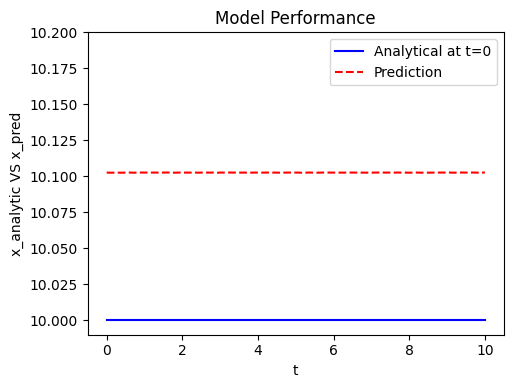

In [28]:
x_plot = np.linspace(0, 10, 100)
t_plot = np.zeros_like(x_plot)
x_pred = model(t).cpu().detach().numpy()
mean_p = np.mean(x_pred)

fig, ax = plt.subplots()
ax.set_ylim(9.99, 10.2)
plt.subplots_adjust(left=0.25, bottom=0.25)
l, = plt.plot(x_plot, x_analytical(t_plot), 'b', label='Analytical at t=0')
p, = plt.plot(x_plot, x_pred, '--r', label='Prediction')
# ax.hlines(mean_p, xmin=0, xmax=10, color='g', linestyle='-', label='Mean of Prediction')
plt.title('Model Performance')
plt.xlabel('t')
plt.ylabel('x_analytic VS x_pred')
plt.legend(loc='upper right');